# BERT fine-tuned classifier for stigma project

Source of original notebook: https://chriskhanhtran.github.io/_posts/2019-12-25-bert-for-sentiment-analysis/

# Installs/imports

In [1]:
!pip install transformers

In [2]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
# from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaModel
from transformers import AdamW, get_linear_schedule_with_warmup

%matplotlib inline

In [3]:
# setup GPU
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


# Load dataset

In [4]:
# # mount google drive if needed

# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
data = pd.read_csv('/content/train.En.csv')
data

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3463,3463,The population spike in Chicago in 9 months is...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3464,3464,You'd think in the second to last English clas...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3465,3465,I’m finally surfacing after a holiday to Scotl...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3466,3466,Couldn't be prouder today. Well done to every ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Drop any examples where the length is likely to exceed BERT input limit
data = data[data['tweet'].str.len() < 1100]

In [7]:
# Set label to use in binary classifcation
LABEL_TO_CLASSIFY = 'sarcastic'

In [8]:
# Drop any rows where there is no label (NaN) for the given construct
data = data[data[LABEL_TO_CLASSIFY].notna()]

In [9]:
positive_samples = data[data[LABEL_TO_CLASSIFY] == 1]
len(positive_samples)

867

In [10]:
negative_samples = data[data[LABEL_TO_CLASSIFY] == 0]
len(negative_samples)

2600

In [11]:
# Sample randomly from negative examples to get equal number of positives and negatives
positive_samples = data[data[LABEL_TO_CLASSIFY] == 1]
negative_samples = data[data[LABEL_TO_CLASSIFY] == 0].sample(n=len(positive_samples), random_state=2020)

In [12]:
data = pd.concat([positive_samples,negative_samples]).reset_index(drop=True)

In [13]:
data['label'] = data[LABEL_TO_CLASSIFY].astype(int)

In [14]:
# Split dataset into train, validation, and test sets

# X_train, temp_text, y_train, temp_labels = train_test_split(data['text'], data['label'], 
#                                                                     random_state=2020, 
#                                                                     test_size=0.25,
#                                                                     stratify=data['label'])

# # we will use temp_text and temp_labels to create validation and test set
# X_val, test_text, y_val, test_labels = train_test_split(temp_text, temp_labels, 
#                                                                 random_state=2020, 
#                                                                 test_size=0.5,
#                                                                 stratify=temp_labels)

X_train, temp_text, y_train, temp_labels = train_test_split(data['tweet'], data['label'], 
                                                                    random_state=2020, 
                                                                    test_size=0.25)

# we will use temp_text and temp_labels to create validation and test set
X_val, test_text, y_val, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2020, 
                                                                test_size=0.5)

In [15]:
# Load the BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=False)
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


Length of encoded posts:


count    1734.000000
mean       29.159746
std        16.375582
min         4.000000
25%        17.000000
50%        26.000000
75%        36.000000
max       124.000000
dtype: float64

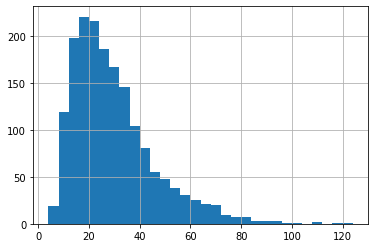

In [16]:
# Analyze post lengths after processing. This block is not required.

all_posts = data['tweet']

# Encode our concatenated data
encoded_posts = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_posts]

# get length of all the messages in the train set
seq_len = [len(i) for i in encoded_posts]

print("\nLength of encoded posts:")
pd.Series(seq_len).hist(bins = 30)

pd.Series(seq_len).describe()

In [17]:
# Specify `MAX_LEN`
MAX_LEN = 200

# Print sentence 1 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_text)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  The only thing I got from college is a caffeine addiction
Token IDs:  [0, 133, 129, 631, 38, 300, 31, 1564, 16, 10, 26604, 7530, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokenizing data...
Tokenizing data...


# Create dataloaders

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

# Define model class

In [19]:
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = RobertaModel.from_pretrained('roberta-base')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.33),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [20]:
def initialize_model(epochs=5):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=3e-5,    # Default learning rate is 1e-3
                      eps=1e-8,    # Default epsilon value is 1e-6
                      weight_decay=.01
                      )
   
    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

# Define training and evaluation loops

In [21]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [22]:
# AUC/Accuracy evaluation function

from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Train model

In [23]:
set_seed(42)    # Set seed for reproducibility
EPOCHS = 7

bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)
train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS, evaluation=True)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  Futu

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.693432   |     -      |     -     |   12.83  
   1    |   40    |   0.692524   |     -      |     -     |   11.95  
----------------------------------------------------------------------
   1    |    -    |   0.692989   |  0.693098  |   51.12   |   26.16  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.693129   |     -      |     -     |   12.74  
   2    |   40    |   0.668971   |     -      |     -     |   11.95  
----------------------------------------------------------------------
   2    |    -    |   0.681345   |  0.673019  |   56.04   |   26.08  
----------------------------------------------------------------

# Define predictor function

In [24]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.7154
Accuracy: 64.98%


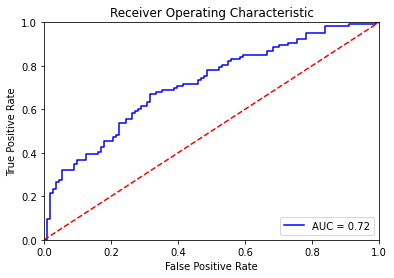

In [25]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [26]:
# Compute predicted probabilities on the validation set
probs = bert_predict(bert_classifier, val_dataloader)

# Get predictions from the probabilities
preds = np.argmax(probs, axis = 1)

# Number of tweets predicted non-negative
print("Number of posts predicted non-negative: ", preds.sum())

Number of posts predicted non-negative:  84


In [27]:
from sklearn.metrics import classification_report
# preds = np.argmax(preds, axis = 1)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.63      0.76      0.69       111
           1       0.68      0.54      0.60       106

    accuracy                           0.65       217
   macro avg       0.66      0.65      0.64       217
weighted avg       0.65      0.65      0.65       217



# Re-train on combined train and validation data

In [28]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)
train(bert_classifier, full_train_dataloader, epochs=EPOCHS)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  Futu

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.694536   |     -      |     -     |   12.75  
   1    |   40    |   0.696203   |     -      |     -     |   12.17  
   1    |   47    |   0.693657   |     -      |     -     |   3.94   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.693543   |     -      |     -     |   12.76  
   2    |   40    |   0.679343   |     -      |     -     |   12.14  
   2    |   47    |   0.699479   |     -      |     -     |   3.94   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
---------------------------------------------------------------

In [29]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
preds = np.argmax(probs, axis = 1)

# Number of tweets predicted non-negative
print("Number of posts predicted non-negative: ", preds.sum())

Number of posts predicted non-negative:  92


In [30]:
from sklearn.metrics import classification_report
# preds = np.argmax(preds, axis = 1)
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.65      0.75      0.70       108
           1       0.71      0.60      0.65       109

    accuracy                           0.67       217
   macro avg       0.68      0.67      0.67       217
weighted avg       0.68      0.67      0.67       217



In [31]:
# output = test_text[preds==1]
# list(output.sample(20))

print('Incorrect negative predictions:\n--------------------')
for sent in test_text[(preds==0) & (test_labels.values==1)]:
  print(sent)
print()
print('Incorrect positive predictions:\n--------------------')
for sent in test_text[(preds==1) & (test_labels.values==0)]:
  print(sent)

Incorrect negative predictions:
--------------------
can't wait to cop tickets to see the cracker quartet
Just disposed of a dead opossum. Good morning!
@ThePartridgePod Defrost the freezer with the cast of Hollyoaks. Any of them that wanted an extra fun trip could pop to the recycling centre with some empty pesto jars. Magic.
I find it hilarious that ‘black and white’ or ‘all or nothing’ thinking is considered a cognitive distortion and is a symptom of several disorders, and yet it remains a pillar of American (and Western) culture.

It’s almost like…. our culture is toxic 🤔
I picked next year's musical already...Electro City. Obvious choice.
Don't let people walk all over you. Or breathe on you. Either one.
Watched 127 hours... Kinda reminded me of this one time I got a bad splinter. Writing a book about it now, hit me up for an autographed copy
@DylanPetit17 @jaredj5 Let's listen to Dylan Petit over actually doctors, biologists and epidemiologists. 🙄
💫jsc bonding nights💫🥰🥳
every tim